# Using Machine Learning Methods to Accelerate MD Simulations

## Yatin Chandar
Under the Direction of Simon Batzner

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

#### Read in Datasets for Nuclei Positions

Hydrogen 1

In [4]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'


data_h1y = []
data_h1z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1y.append(float(line.strip()[25:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1z.append(float(line.strip()[42:52]))
        count +=1



Hydrogen 2

In [5]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'


data_h2y = []
data_h2z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2y.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2z.append(float(line.strip()[42:52]))
        count +=1



Oxygen

In [6]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'


data_oy = []
data_oz = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oy.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oz.append(float(line.strip()[42:52]))
        count +=1



#### Read in Dataset for Corresponding Energies

In [7]:
H2O_en = '/Users/yatin/Documents/water/energies.txt'


energy = []

with open(H2O_en, 'r') as outf:
    for line in outf:
        energy.append(float(line))

#### Calculate Geometries

Bond Lengths

In [8]:
bond_1 = []
bond_2 = []
side3 = []
for loc in range(0, len(data_oy)):
    bond_1.append(math.sqrt((data_oy[loc]-data_h1y[loc])**2+(data_oz[loc]-data_h1z[loc])**2))
    bond_2.append(math.sqrt((data_oy[loc]-data_h2y[loc])**2+(data_oz[loc]-data_h2z[loc])**2))
    side3.append(math.sqrt((data_h2y[loc]-data_h1y[loc])**2+(data_h2z[loc]-data_h1z[loc])**2))

Bond Angles

In [9]:
angle = []

for location in range(0,len(data_oy)):
    angle.append(np.arccos((bond_1[location]**2+bond_2[location]**2-side3[location]**2)/(2*bond_1[location]*bond_2[location])))

#### Append Geometry Values to Create Dataset

In [10]:
dataset = []

for i in range (0, len(data_oy)):
    l = []
    l.append(bond_1[i])
    l.append(bond_2[i])
    l.append(angle[i])
    dataset.append(l)

### Define Functions

Define Number of Clusters

In [470]:
cluster = int(input())

5


Define Distance Formula

In [471]:
def distance(x1, y1, z1, x2, y2, z2):
    dist = math.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
    return dist

Split Train and Test Data

In [472]:
def split(X):
    
    model = KMeans(n_clusters=cluster)
    minsos = []
    l = []
    closepts = []
    m = []
    n = []
    closest = []
    closeindex = []
    smallest = 9999
    for i in range(50):

        model.fit(X)
        
        l = []
        m = []
        n = []
        for i in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}:
            for j in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}[i]:
                if distance(model.cluster_centers_[i][0], model.cluster_centers_[i][1], model.cluster_centers_[i][2], dataset[j][0], dataset[j][1], dataset[j][2]) < smallest:
                    smallest = distance(model.cluster_centers_[i][0], model.cluster_centers_[i][1], model.cluster_centers_[i][2], dataset[j][0], dataset[j][1], dataset[j][2])
                    closest = dataset[j]
                    closestlabel = j
            l.append(smallest)
            m.append(closest)
            n.append(closestlabel)
            smallest = 9999
        minsos.append(l)
        closepts.append(m)
        closeindex.append(n)
    
    
    smallestsos = 9999
    sos = 0
    mark = 0
    for i in range(len(minsos)):
        sos = 0
        for j in minsos[i]:
            sos = sos+j**2
        if sos < smallestsos:
            smallestsos = sos
            mark = i
    
    trainingset = closepts[mark]
    totalindex = closeindex[mark]
    

    testset = []
    testen = []
    for k in dataset:
        testset.append(k)
    for k in energy:
        testen.append(k)
    for i in range(len(dataset)):
        for j in range(len(trainingset)):
            if trainingset[j] == dataset[i]:
                testset.remove(trainingset[j])
                testen.remove(energy[i])
    test = np.array(testset)
    testenergy = np.array(testen)
    

    A = trainingset
    B = []
    for i in totalindex:
        B.append(energy[i])
    training = np.array(A)
    trainingenergy = np.array(B)
    return training, trainingenergy, test, testenergy, model, cluster

Determine Mean Absolute Error

In [473]:
from sklearn.metrics import mean_absolute_error

def error_det(pred, correct):
    err = mean_absolute_error(correct, pred)
    return err

#### Run Functions

Generate Training and Test Data

In [474]:
training, trainingenergy, test, testenergy, model, cluster = split(dataset)

Visualization of Clustering

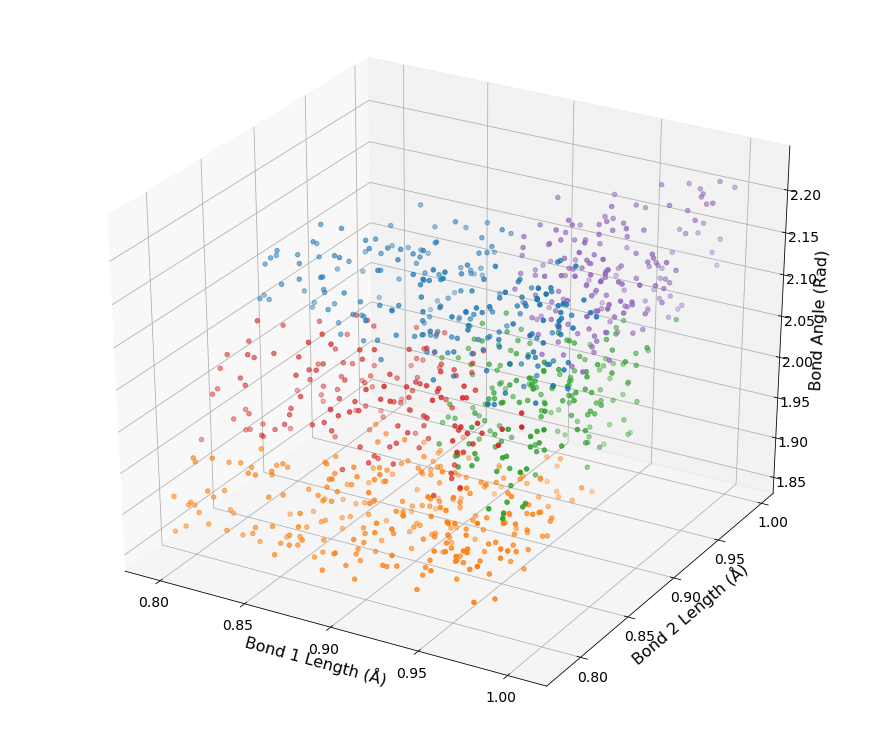

In [475]:
cluster_dict = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
index_by_cluster = []
data_by_cluster = []
for group in range(cluster):
    index_by_cluster.append(cluster_dict[group])
    

for j in index_by_cluster:
    cluster_list = []
    for k in j:
        for i in range(len(dataset)):
            if k == i:
                cluster_list.append(dataset[k])
    data_by_cluster.append(cluster_list)
    
data_by_cluster_array = []
for i in data_by_cluster:
    data_by_cluster_array.append(np.array(i).T)

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)

for i in data_by_cluster_array:
    ax.scatter(i[0, :], i[1, :], i[2, :])
    
ax.view_init()
ax.set_zlabel('Bond Angle (Rad)', fontsize = 16)
plt.xlabel('Bond 1 Length (Å)', fontsize = 16)
plt.ylabel('Bond 2 Length (Å)', fontsize = 16)
plt.savefig("plot_of_"+str(cluster)+"_clusters", dpi = 300)
plt.show()

### Gaussian Process Regression

#### Define GP Regressor and Fit to Data

In [476]:
gp = GaussianProcessRegressor(n_restarts_optimizer=20)

In [477]:
gp.fit(training, trainingenergy)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=20, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

#### Predict

On Training Data

In [478]:
target_pred_t, std_t = gp.predict(training, return_std = True)
error_det(trainingenergy, target_pred_t)

3.3988722134381535e-05

On Test Data

In [479]:
target_pred, std = gp.predict(test, return_std = True)
error_det(testenergy, target_pred)

38.009207186810926

On All Data

In [480]:
target_pred_all, std_all = gp.predict(dataset, return_std = True)
error_det(energy, target_pred_all)

37.81916132082048

#### Comparison of GP and DFT

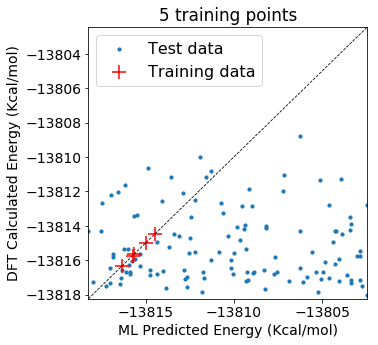

In [481]:
plt.figure(figsize = (5, 5))
plt.scatter(target_pred, testenergy, s = 10, marker = 'o', label='Test data')
plt.scatter(target_pred_t, trainingenergy, s = 200, marker = '+', c = 'r', label = 'Training data')
plt.plot(np.linspace(testenergy.min(), testenergy.max()), np.linspace(testenergy.min(), testenergy.max()), 'k--', linewidth = .8)
plt.legend(fontsize = 16)
plt.ylabel('DFT Calculated Energy (Kcal/mol)', fontsize = 14)
plt.xlabel('ML Predicted Energy (Kcal/mol)', fontsize = 14)
plt.title(str(cluster)+' training points')
plt.xlim((testenergy.min(), testenergy.max()))
plt.ylim((testenergy.min(), testenergy.max()))
plt.savefig("parity_plot_"+ str(cluster), dpi = 300, bbox_inches='tight')
plt.show()

## Visualizations of Errors/Uncertainties

In [482]:
distance_by_cluster = []
for i in range(len(index_by_cluster)):
    distance_cluster = []
    for j in data_by_cluster[i]:
        distance_cluster.append(distance(model.cluster_centers_[i][0], model.cluster_centers_[i][1], model.cluster_centers_[i][2], j[0], j[1], j[2]))
    distance_by_cluster.append(distance_cluster) 

energy_by_cluster = []
for i in index_by_cluster:
    energy_cluster = []
    for j in i:
        energy_cluster.append(energy[j])
    energy_by_cluster.append(energy_cluster)
    
predictions_by_cluster = []
for i in index_by_cluster:
    predictions_cluster = []
    for j in i:
        predictions_cluster.append(target_pred_all[j])
    predictions_by_cluster.append(predictions_cluster)

re_by_cluster = []
for i in range(len(index_by_cluster)):
    re_cluster = []
    for j in range(len(index_by_cluster[i])):
        re_cluster.append((abs((predictions_by_cluster[i][j] - energy_by_cluster[i][j])/(energy_by_cluster[i][j]))))
    re_by_cluster.append(re_cluster)



In [483]:
uncertainty = []
for i in range(len(data_by_cluster)):
    uncert_cluster = []
    for j in range(len(data_by_cluster[i])):
        target_pred_cluster, std_cluster = gp.predict(np.array(data_by_cluster[i][j]).reshape(1,-1), return_std = True)
        uncert_cluster.append(std_cluster)
    uncertainty.append(uncert_cluster)

uncertainty_by_cluster = []
for i in uncertainty:
    uncertainty_by_cluster.append(list(i))

## Compare Geometric Distance to Error

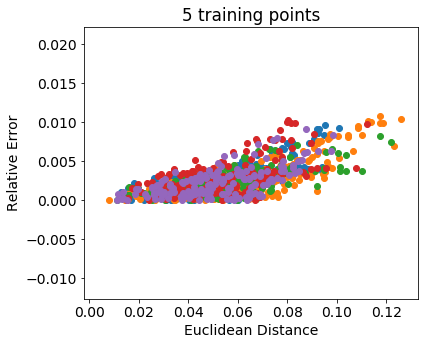

In [484]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (6, 5))
plt.xlabel('Euclidean Distance', fontsize = 14)
plt.ylabel('Relative Error', fontsize = 14)
plt.title(str(cluster)+' training points')
for i in range(len(model.cluster_centers_)):
    plt.scatter(distance_by_cluster[i], re_by_cluster[i])
plt.savefig("Distance_Error_"+ str(cluster), dpi = 300, bbox_inches='tight')
plt.show()

## Compare Geometric Distance to Uncertainty

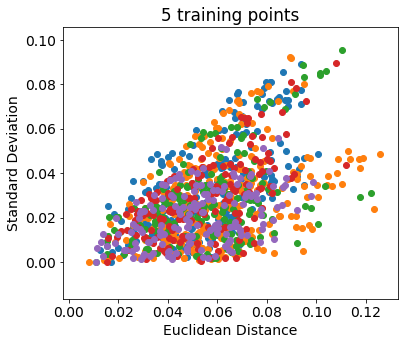

In [486]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (6, 5))
plt.xlabel('Euclidean Distance', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title(str(cluster)+' training points')
for i in range(len(model.cluster_centers_)):
    plt.scatter(distance_by_cluster[i], uncertainty_by_cluster[i])
plt.savefig("Distance_Uncertainty_"+ str(cluster), dpi = 300, bbox_inches='tight')
plt.show()

## Compare Uncertainty to Error

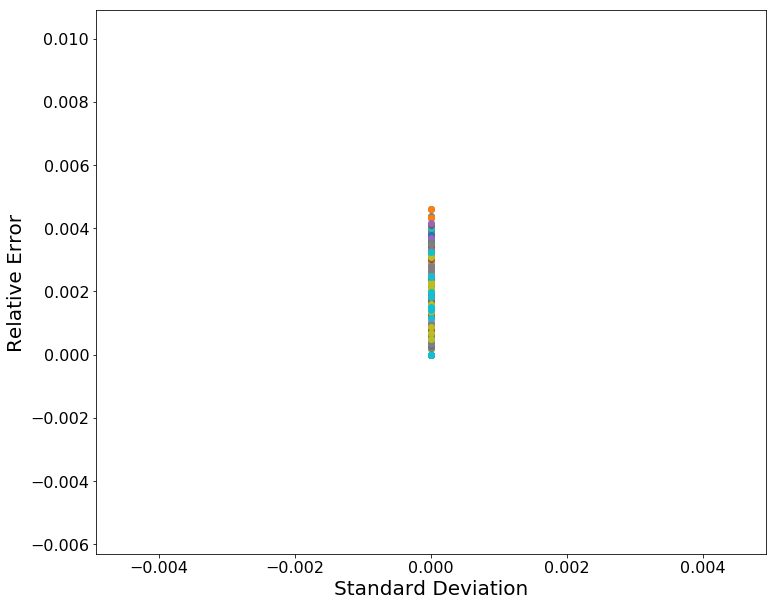

In [109]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (12, 10))
plt.xlabel('Standard Deviation', fontsize = 20)
plt.ylabel('Relative Error', fontsize = 20)

for i in range(len(model.cluster_centers_)):
    plt.scatter(re_by_cluster[i], uncertainty_by_cluster[i])
plt.savefig("Error_Uncertainty_"+ str(cluster), dpi = 300)
plt.show()    


In [16]:
x_axis = []
y_axis = []
for i in range(1,100):
    training, trainingenergy, test, testenergy, model, cluster = split(dataset, i)
    print(i)
    gp = GaussianProcessRegressor(n_restarts_optimizer=20)
    gp.fit(training, trainingenergy)
    target_pred, std = gp.predict(test, return_std = True)
    errorplot = error_det(testenergy, target_pred)
    x_axis.append(i)
    y_axis.append(errorplot)
print(y_axis)

1
2
3
4
5
6
7
8
9
10
11
12


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[107.71368092605707, 69.27127290331723, 180.64548684319843, 125.84665635675813, 27.559872178440177, 19.486571892016695, 21.502605383931336, 17.247112291825598, 9.894604517578358, 3.3415363666602436, 4.812873277003163, 2.6725827320507727, 0.45890900779327615, 0.43304520419930187, 0.4064207546509028, 0.6145838460376796, 0.20209337894808352, 0.2505547384630268, 0.2575172292551814, 0.190515768260131, 0.12972829223342305, 0.19888591445476345, 0.10508345739204145, 0.12248947129994316, 0.1077804009652792, 0.07354819263315554, 0.07719207311495367, 0.04433824216683416, 0.06793897493480472, 0.06189825696419763, 0.03356199519925695, 0.04034178262650844, 0.03522102120674548, 0.05225753342600426, 0.025041346482327795, 0.03308220077002842, 0.0

In [490]:
print(y_axis[19])

0.190515768260131


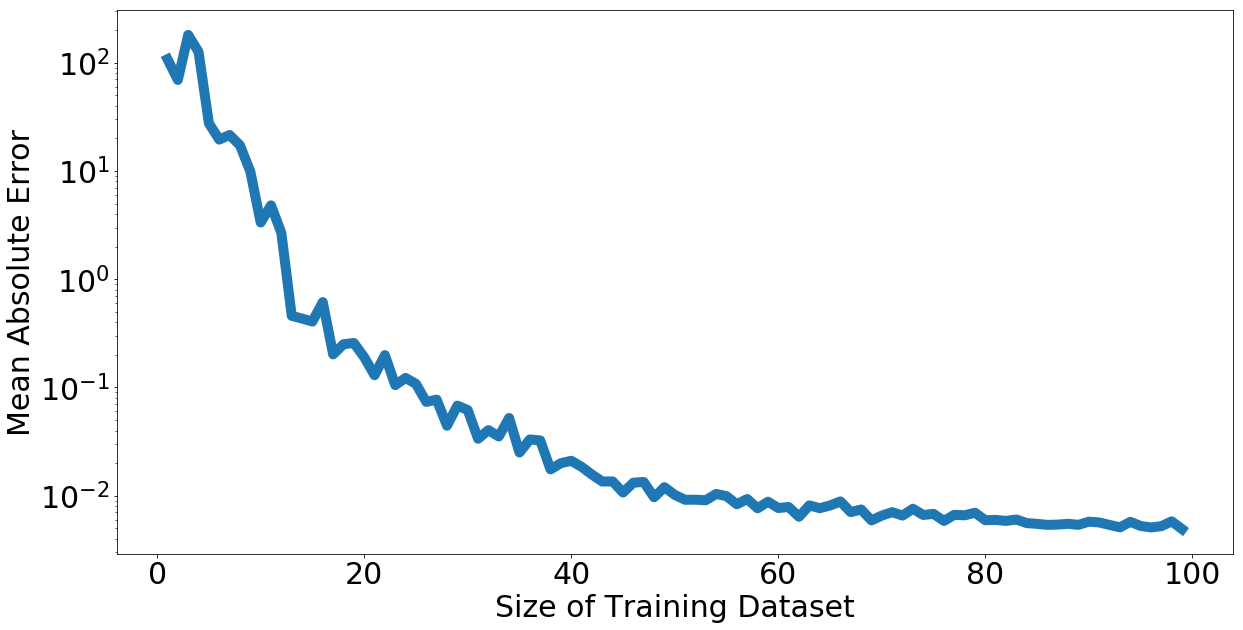

In [342]:

plt.rcParams.update({'font.size': 30})
plt.figure(figsize = (20, 10))
plt.xlabel('Size of Training Dataset', fontsize = 30)
plt.ylabel('Mean Absolute Error', fontsize = 30)
plt.yscale('log')



plt.plot(x_axis,y_axis, linewidth=10)



plt.savefig("Mean_Absolute_Error_tp", dpi = 300,bbox_inches='tight')
plt.show()


# References
1. Jon Vandermause, Steven Torrisi, Simon Batzner (https://github.com/simonbatzner/ML-electron-density)
2. Brockherde, F., Vogt, L., Li, L., Tuckerman, M. E., Burke, K., & Müller, K. R. (2017). Bypassing the Kohn-Sham equations with machine learning. Nature communications, 8(1), 872.
3. Data from: http://quantum-machine.org/datasets/